# Sea-ice and lead classification using IRIS: an opportunity for citizen science?

Intelligently Reinforced Image Segmentation (IRIS) combines manual user classification and machine learning to qiuckly and accurately classify pixels in images. This method is particularly effective for classifying sea-ice and leads, which can then be used as training data for a model which can be rolled out on new images that it hasn't been trained on.

This notebook takes images which have been classified in IRIS, combines them into a single training dataset, and compares the resulting model to those trained on only single images. Three sample images are used, but this can theoretically be scaled up to any number of images in a single directory, although this will substantially increase the run-time.

In [47]:
# import required packages
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import layers, models


In [48]:
# load image as numpy array
image = np.load('/home/rhtwe/UCL/ai4eo/assignment_2/image.npy')

# define and extract region of interest (roi)
x1, y1, x2, y2 = [100, 400, 300, 700]
roi = image[y1:y2, x1:x2]

# read in the mask file
mask = cv2.imread('/home/rhtwe/UCL/ai4eo/assignment_2/mask.png', cv2.IMREAD_UNCHANGED)

# Because the mask file is in RGB which has 3 channels, so we should convert it into binary mask as array with only 0 and 1 values
binary_mask = np.where(mask[:,:,0] == 0, 1, 0)


Check that image and mask are aligned:

(-0.5, 199.5, 299.5, -0.5)

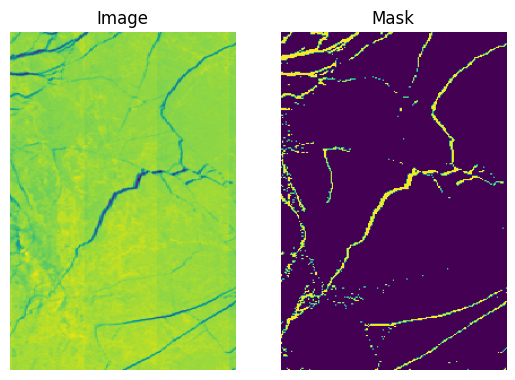

In [49]:
# Extract channels 1, 2, and 3
channel_1 = roi[:,:,4]  # 0-based indexing for the first channel
rgb_image = np.stack([channel_1], axis=-1) # You can add more channels if you want

# plot image and mask
plt.subplot(121)
plt.imshow(rgb_image)
plt.title("Image")
plt.axis('off')

plt.subplot(122)
plt.imshow(binary_mask)
plt.title("Mask")
plt.axis('off')

Because we care about the pixels that are around a given pixel, not just the pixel itself, we split the image up into a number of patches, and make sure the size of the mask is consistent:

In [50]:
patches = []
# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

# Trim the mask to exclude boundary labels
trimmed_mask = binary_mask[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_mask.flatten()

print(f'Shape of patches_array: {patches_array.shape}')
print(f'Shape of labels: {labels.shape}')


Shape of patches_array: (59004, 3, 3, 21)
Shape of labels: (59004,)


Having secured the input data, there remains an essential step to address: managing data imbalance. Data imbalance can skew the results and compromise the accuracy of our analysis, thus it's crucial that the two classes are balanced, each having more or less an equivalent quantity. This ensures a more reliable and equitable comparison and analysis. Therefore, we abandom the training and testing sets above and create new ones.


In [51]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

# Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
num_class = 9396 # Adjust it to the amount you get

# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]


# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train, X_test, y_train, y_test = train_test_split(balanced_patches, balanced_labels, test_size=0.1, random_state=42)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 56030, 1: 2974}
{0: 8432, 1: 2701}


Check sizes of training and testing data:

In [52]:
print(f'X_train: {np.shape(X_train)}')
print(f'X_test: {np.shape(X_test)}')


X_train: (11133, 3, 3, 21)
X_test: (1237, 3, 3, 21)


## Convolutional Neural Network

In [53]:
# X is the rgb file, y is the mask. Model is predicting y based on X.

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3, 3, 21), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
# Add additional convolutional and pooling layers as needed
# ...

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 is the number of classes

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

#model.save('/home/rhtwe/UCL/ai4eo/assignment_2/model_cnn')

Epoch 1/10
348/348 [==============================] - 2s 3ms/step - loss: 0.5697 - accuracy: 0.7552 - val_loss: 0.5041 - val_accuracy: 0.7793
Epoch 2/10
348/348 [==============================] - 1s 2ms/step - loss: 0.5196 - accuracy: 0.7598 - val_loss: 0.4641 - val_accuracy: 0.7801
Epoch 3/10
348/348 [==============================] - 1s 2ms/step - loss: 0.4804 - accuracy: 0.7882 - val_loss: 0.4023 - val_accuracy: 0.8278
Epoch 4/10
348/348 [==============================] - 1s 2ms/step - loss: 0.4274 - accuracy: 0.8300 - val_loss: 0.3567 - val_accuracy: 0.8698
Epoch 5/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3724 - accuracy: 0.8559 - val_loss: 0.3134 - val_accuracy: 0.8795
Epoch 6/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3364 - accuracy: 0.8768 - val_loss: 0.2861 - val_accuracy: 0.8973
Epoch 7/10
348/348 [==============================] - 1s 2ms/step - loss: 0.3005 - accuracy: 0.8926 - val_loss: 0.2767 - val_accuracy: 0.9208
Epoch 

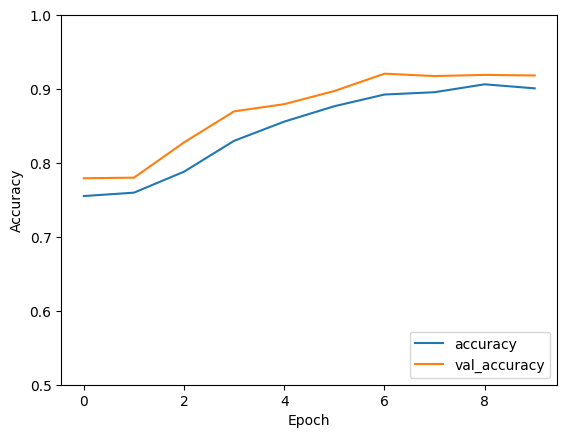

In [54]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Prepare images and masks

In [14]:
image = np.load('/home/rhtwe/iris/IRIS_Toy_Data/image2.npy')

# define regions of interest
rois = [[100, 400,  300, 700],
        [100, 1000, 300, 1300],
        [100, 700,  300, 1000]]

roi_images = []
roi_masks = []
for roi in rois:
    x1, y1, x2, y2 = [roi[0], roi[1], roi[2], roi[3]]
    region = image[y1:y2, x1:x2, :]
    np.save(f'/home/rhtwe/UCL/ai4eo/final_project/images/image_{x1}_{y1}_{x2}_{y2}', region)
    mask = cv2.imread(f'/home/rhtwe/UCL/ai4eo/final_project/images/mask_{x1}_{y1}_{x2}_{y2}.png', cv2.IMREAD_UNCHANGED)
    binary_mask = np.where(mask[:,:,0] == 0, 1, 0)
    roi_images.append(region)
    roi_masks.append(binary_mask)


Check that the images and masks align:

(-0.5, 199.5, 299.5, -0.5)

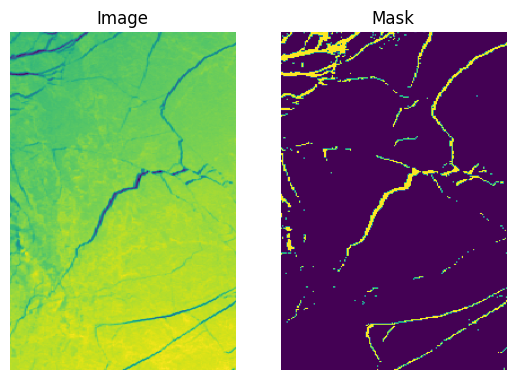

In [15]:
# Extract channels 1, 2, and 3
channel_1 = roi_images[0][:,:,4]  # 0-based indexing for the first channel
rgb_image = np.stack([channel_1], axis=-1) # You can add more channels if you want

# plot image and mask
plt.subplot(121)
plt.imshow(rgb_image)
plt.title("Image")
plt.axis('off')

plt.subplot(122)
plt.imshow(roi_masks[0])
plt.title("Mask")
plt.axis('off')


### Combine seperate images and masks into a single training/testing dataset

Does using more data improve the prediction?

Can't assume they'll be in the same order. Need to match image to mask, assuming they have the same file name apart from the 'mask' or 'image' prefix

Retrieve file names and separate images from masks:

In [55]:
files = os.listdir('/home/rhtwe/UCL/ai4eo/final_project/images')
images = [file for file in files if (file[0:5]=='image')]
masks = [file for file in files if (file[0:4]=='mask')]

# make sure masks and images are in the same order
ordered_images = []
ordered_masks = []
for image in images:
    image_id = image[6:-4]
    ordered_images.append(image)
    ordered_masks.append(f'mask_{image_id}.png')


Plot a sample image to check it aligns with its mask:

(-0.5, 199.5, 299.5, -0.5)

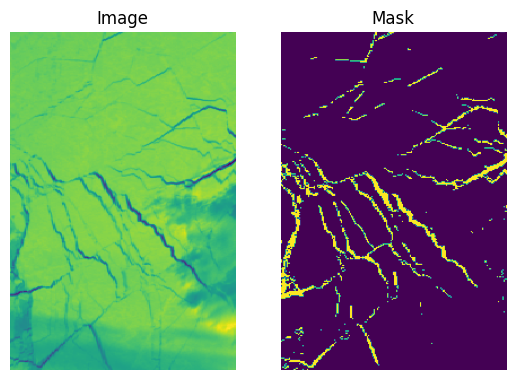

In [92]:
# load image as numpy array
image = np.load(f'/home/rhtwe/UCL/ai4eo/final_project/images/{ordered_images[2]}')
# read in the mask file
mask = cv2.imread(f'/home/rhtwe/UCL/ai4eo/final_project/images/{ordered_masks[2]}', cv2.IMREAD_UNCHANGED)
binary_mask = np.where(mask[:,:,0] == 0, 1, 0)

# Extract channels 1, 2, and 3
channel_1 = image[:,:,4]  # 0-based indexing for the first channel
rgb_image = np.stack([channel_1], axis=-1) # You can add more channels if you want

# plot image and mask
plt.subplot(121)
plt.imshow(rgb_image)
plt.title("Image")
plt.axis('off')

plt.subplot(122)
plt.imshow(binary_mask)
plt.title("Mask")
plt.axis('off')


Prepare data for model, an image at a time:

In [107]:
histories = []
for f in range(len(ordered_images)):
    image = np.load(f'/home/rhtwe/UCL/ai4eo/final_project/images/{ordered_images[f]}')
    mask = cv2.imread(f'/home/rhtwe/UCL/ai4eo/final_project/images/{ordered_masks[f]}', cv2.IMREAD_UNCHANGED)
    binary_mask = np.where(mask[:,:,0] == 0, 1, 0)

    patches = []
    # Iterate over the height and width of the roi, excluding the border pixels
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            # Extract a (3, 3, 21) patch centered around the pixel (i, j)
            patch = image[i-1:i+2, j-1:j+2, :]
            patches.append(patch)

    # Convert the list of patches to a numpy array
    patches_array = np.array(patches)

    # Trim the mask to exclude boundary labels
    trimmed_mask = binary_mask[1:-1, 1:-1]

    # Flatten the trimmed mask to get a 1D array of labels
    labels = trimmed_mask.flatten()

    print(f'Shape of patches_array: {patches_array.shape}')
    print(f'Shape of labels: {labels.shape}')

    # Initially, we examine the quantity of each class present in the dataset
    unique, counts = np.unique(labels, return_counts=True)
    print(dict(zip(unique, counts)))

    # Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
    num_class = 9396 # Adjust it to the amount you get

    # Extract indices of both classes
    indices_class_0 = np.where(labels == 0)[0]
    indices_class_1 = np.where(labels == 1)[0]

    # Randomly sample 9396 indices from class 0
    sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

    # Combine the sampled indices with indices of class 1
    combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

    # Extract the corresponding patches and labels
    balanced_patches = patches_array[combined_indices]
    balanced_labels = labels[combined_indices]

    # Split the balanced dataset into training and testing sets with a 1:9 ratio
    X_train, X_test, y_train, y_test = train_test_split(balanced_patches, balanced_labels, test_size=0.1, random_state=42)

    # Check the balance in y_train_balanced
    unique, counts = np.unique(y_train, return_counts=True)
    print(dict(zip(unique, counts)))

    # X is the rgb file, y is the mask. Model is predicting y based on X.

    # Define the model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3, 3, 21), padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    # Add additional convolutional and pooling layers as needed
    # ...

    # Add dense layers for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # 10 is the number of classes

    # Compile and train the model
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    histories.append(history)


Shape of patches_array: (59004, 3, 3, 21)
Shape of labels: (59004,)
{0: 55973, 1: 3031}
{0: 8437, 1: 2747}
Epoch 1/10
350/350 [==============================] - 3s 4ms/step - loss: 0.7751 - accuracy: 0.7887 - val_loss: 0.4831 - val_accuracy: 0.8158
Epoch 2/10
350/350 [==============================] - 1s 4ms/step - loss: 0.4196 - accuracy: 0.8396 - val_loss: 0.4263 - val_accuracy: 0.8544
Epoch 3/10
350/350 [==============================] - 2s 4ms/step - loss: 0.3628 - accuracy: 0.8551 - val_loss: 0.3435 - val_accuracy: 0.9236
Epoch 4/10
350/350 [==============================] - 2s 6ms/step - loss: 0.3954 - accuracy: 0.8442 - val_loss: 0.3439 - val_accuracy: 0.9220
Epoch 5/10
350/350 [==============================] - 2s 5ms/step - loss: 0.3249 - accuracy: 0.8725 - val_loss: 0.6002 - val_accuracy: 0.8254
Epoch 6/10
350/350 [==============================] - 2s 5ms/step - loss: 0.3311 - accuracy: 0.8725 - val_loss: 0.2383 - val_accuracy: 0.9043
Epoch 7/10
350/350 [=====================

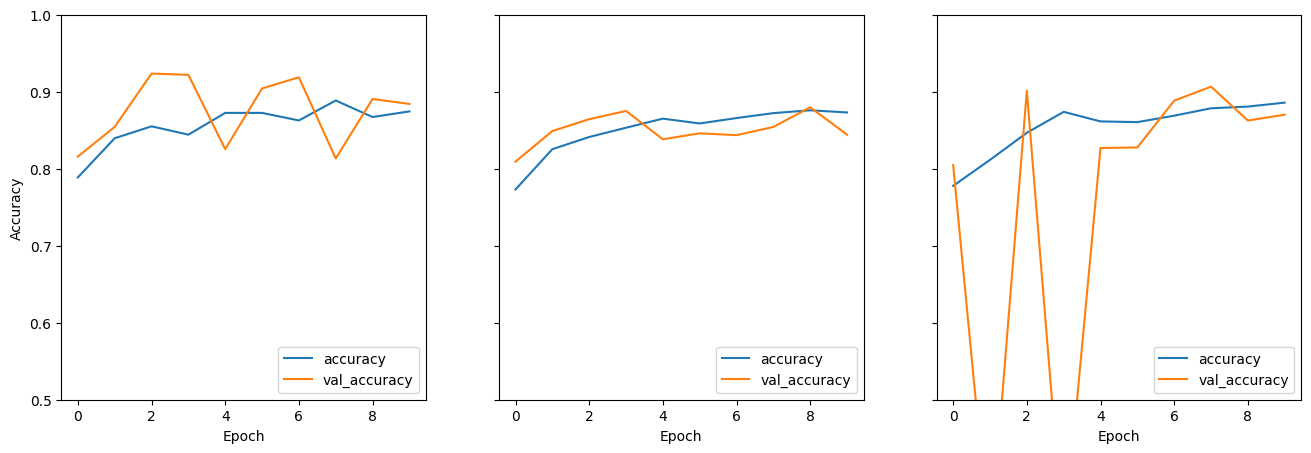

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5), sharey=True)

ax1.plot(histories[0].history['accuracy'], label='accuracy')
ax1.plot(histories[0].history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.5, 1])
ax1.legend(loc='lower right')

ax2.plot(histories[1].history['accuracy'], label='accuracy')
ax2.plot(histories[1].history['val_accuracy'], label = 'val_accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0.5, 1])
ax2.legend(loc='lower right')

ax3.plot(histories[2].history['accuracy'], label='accuracy')
ax3.plot(histories[2].history['val_accuracy'], label = 'val_accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylim([0.5, 1])
ax3.legend(loc='lower right')


Combine images into one larger training dataset:

In [103]:
combined_X_train, combined_X_test, combined_y_train, combined_y_test = [], [], [], []
for f in range(len(ordered_images)):
    image = np.load(f'/home/rhtwe/UCL/ai4eo/final_project/images/{ordered_images[f]}')
    mask = cv2.imread(f'/home/rhtwe/UCL/ai4eo/final_project/images/{ordered_masks[f]}', cv2.IMREAD_UNCHANGED)
    binary_mask = np.where(mask[:,:,0] == 0, 1, 0)

    patches = []
    # Iterate over the height and width of the roi, excluding the border pixels
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            # Extract a (3, 3, 21) patch centered around the pixel (i, j)
            patch = image[i-1:i+2, j-1:j+2, :]
            patches.append(patch)

    # Convert the list of patches to a numpy array
    patches_array = np.array(patches)

    # Trim the mask to exclude boundary labels
    trimmed_mask = binary_mask[1:-1, 1:-1]

    # Flatten the trimmed mask to get a 1D array of labels
    labels = trimmed_mask.flatten()

    # Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
    num_class = 9396 # Adjust it to the amount you get

    # Extract indices of both classes
    indices_class_0 = np.where(labels == 0)[0]
    indices_class_1 = np.where(labels == 1)[0]

    # Randomly sample 9396 indices from class 0
    sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

    # Combine the sampled indices with indices of class 1
    combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

    # Extract the corresponding patches and labels
    balanced_patches = patches_array[combined_indices]
    balanced_labels = labels[combined_indices]

    # Split the balanced dataset into training and testing sets with a 1:9 ratio
    X_train, X_test, y_train, y_test = train_test_split(balanced_patches, balanced_labels, test_size=0.1, random_state=42)
    combined_X_train.append(X_train)
    combined_X_test.append(X_test)
    combined_y_train.append(y_train)
    combined_y_test.append(y_test)

X_train = np.concatenate(combined_X_train)
X_test = np.concatenate(combined_X_test)
y_train = np.concatenate(combined_y_train)
y_test = np.concatenate(combined_y_test)


Now let's run the model. It takes longer even with only three combined images rather than one (~20s vs ~55s); scaling this up will require substantial computational resources and a more efficient method may be required.

In [104]:
# X is the rgb file, y is the mask. Model is predicting y based on X.

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3, 3, 21), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
# Add additional convolutional and pooling layers as needed
# ...

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 is the number of classes

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
1195/1195 [==============================] - 4s 3ms/step - loss: 0.5260 - accuracy: 0.8000 - val_loss: 0.3754 - val_accuracy: 0.8397
Epoch 2/10
1195/1195 [==============================] - 3s 3ms/step - loss: 0.3784 - accuracy: 0.8475 - val_loss: 0.3384 - val_accuracy: 0.8602
Epoch 3/10
1195/1195 [==============================] - 4s 3ms/step - loss: 0.3713 - accuracy: 0.8519 - val_loss: 0.3353 - val_accuracy: 0.8578
Epoch 4/10
1195/1195 [==============================] - 4s 3ms/step - loss: 0.3341 - accuracy: 0.8701 - val_loss: 0.4194 - val_accuracy: 0.8439
Epoch 5/10
1195/1195 [==============================] - 8s 7ms/step - loss: 0.3368 - accuracy: 0.8696 - val_loss: 0.2882 - val_accuracy: 0.8818
Epoch 6/10
1195/1195 [==============================] - 9s 7ms/step - loss: 0.3147 - accuracy: 0.8796 - val_loss: 0.2680 - val_accuracy: 0.9049
Epoch 7/10
1195/1195 [==============================] - 6s 5ms/step - loss: 0.3058 - accuracy: 0.8830 - val_loss: 0.2340 - val_accuracy:

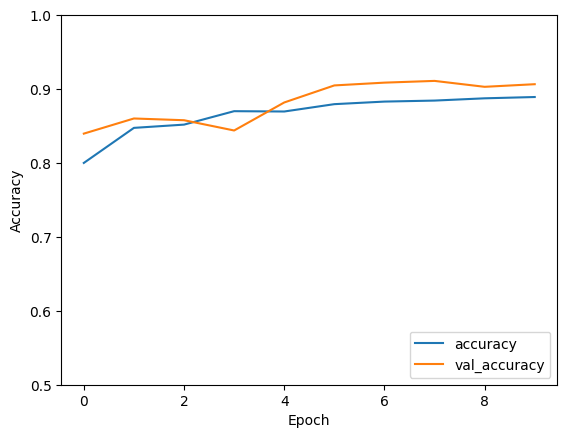

In [105]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
